In [1]:
import csv
import datetime
import glob

import pickle
import scipy.sparse
import time
import zipfile 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter

sns.set_style('whitegrid')
sns.set_palette('pastel')
sns.set_context('poster')

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
print(torch.cuda.device_count())

In [111]:
with open('/content/drive/MyDrive/refit_data_by_category.pk', 'rb') as f:
    data = pickle.load(f)
    
train, test = data['train'], data['test']

# **DSC & VSC (regular & transfer)**

### Define models

In [114]:
class DSC(nn.Module):
    def __init__(self, input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=False, DD_step=False):
        super(DSC, self).__init__()
        self.enable_transfer_learning = enable_transfer_learning
        self.DD_step = DD_step # for now
        self.encoder = nn.Sequential(
            nn.Conv1d(1, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.Conv1d(num_filters, num_filters, filter_size, padding=filter_size//2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(num_filters, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.ConvTranspose1d(num_filters, 1, filter_size, padding=filter_size//2),
            nn.LeakyReLU(),
        )
        #self.classifier = nn.Linear(encoding_dim, output_size)

        if self.DD_step:
            for param in self.encoder[:2].parameters():
                param.requires_grad = False

        if self.enable_transfer_learning:
            for param in self.encoder[:1].parameters():
                param.requires_grad = False
        
    def forward(self, x):
        z = self.encoder(x)
        a = torch.sign(z) * torch.relu(torch.abs(z) - 0.2)   # <--------- here is where the sparsity penalty occurs. The threshold is 0.01
        y_hat = self.decoder(a)
        #x_hat
        #y_hat = self.classifier(a.mean(dim=2))
        return y_hat, a, self.encoder[0].weight

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VSC(nn.Module):
    def __init__(self, input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=False, DD_step=False):#, beta):
        super(VSC, self).__init__()
        
        self.num_filters = num_filters
        self.encoding_dim = encoding_dim
        self.enable_transfer_learning = enable_transfer_learning
        self.DD_step = DD_step
        #self.beta = beta

        self.encoder = nn.Sequential(
            nn.Conv1d(1, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.Conv1d(num_filters, num_filters, filter_size, padding=filter_size//2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(num_filters, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.ConvTranspose1d(num_filters, 1, filter_size, padding=filter_size//2),
            nn.LeakyReLU(),
        )

        if self.DD_step:
            for param in self.encoder[:2].parameters():
                param.requires_grad = False

        if self.enable_transfer_learning:
            for param in self.encoder[:1].parameters():
                param.requires_grad = False

    def forward(self, x):
        z = self.encoder(x)
        mean = z.mean(dim=2)
        log_var = z.var(dim=2).log()
        
        # Sample from a spike and slab?*
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(z)  # not like std, more like z
        z = eps * std.unsqueeze(-1).repeat(1, 1, 170) + mean.unsqueeze(-1).repeat(1, 1, 170)

        # sparsify
        a = torch.sign(z) * F.relu(torch.abs(z) - 0.2)
        #a = a.unsqueeze(-1).repeat(1, 1, 171) # instead of repeat, smaple and create the 3rd dimension
        #print(a.shape, z.shape)
        y_hat = self.decoder(a)
        #kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return y_hat, a, mean, log_var#, kl_loss


### Define training functions

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [117]:
def train_on_week_and_category(week, cat, learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False, target_ind=None, use_only_target_for_everything=False):
  # split data
  if enable_transfer_learning:
    X, X_t = train[week]['X_bar'].T.values[:8,:], train[week]['X_bar'].T.values[8:,:]
    y_cat, y_cat_t = train[week]['X'][cat].T.values[:8,:], train[week]['X'][cat].T.values[8:,:]
  elif use_only_target_for_everything:
    X = train[week]['X_bar'].T.values[8:,:]
    y_cat = train[week]['X'][cat].T.values[8:,:]
  else:
    X = train[week]['X_bar'].T.values
    y_cat = train[week]['X'][cat].T.values

  # 1) Deep Sparse Coding step, input and output are the same
  model = DSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=False)
  model.to(device)
  # Define loss and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  print('----> Training for', cat)
  for epoch in range(num_epochs):
    running_loss = 0.0
    inputs, targets = torch.Tensor(y_cat).unsqueeze(1).to(device), torch.Tensor(y_cat).unsqueeze(1).to(device)
    optimizer.zero_grad()

    y_hat, a, encoder = model(inputs)
   #print('a_matrix is {} % sparse'.format(round(100*len(np.where(a.cpu() < 0.1)[0])/(13*25*170), 3)))
    #print('shapes',y_hat.shape, targets.shape)
    loss = criterion(y_hat, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Print average loss for epoch (every n epochs)
    if epoch % display_every_n_epochs == 0:
      print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X)))
  
  weights = (model.encoder[0].weight, model.encoder[2].weight)

################################################################################################################################################

#2) transfer learning
  if enable_transfer_learning:
    # model ,loss and optimizer
    transfer_model = DSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=True)
    transfer_model.to(device)
    transfer_criterion = nn.MSELoss()
    transfer_optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

    print('----> Transfer training for {}'.format(cat))

    for epoch in range(num_epochs):
      running_loss = 0.0
      inputs, targets = torch.Tensor(y_cat_t).unsqueeze(1).to(device), torch.Tensor(y_cat_t).unsqueeze(1).to(device)
      transfer_optimizer.zero_grad()

      transfer_model.encoder[0].weight = weights[0]
      transfer_model.encoder[2].weight = weights[1]
      #transfer_model.encoder[4].weight = model.encoder[4].weight
      
      y_hat, a, encoder = transfer_model(inputs)
      # Compute loss and backpropagate
      loss = transfer_criterion(y_hat, targets)
      loss.backward()
      transfer_optimizer.step()

      running_loss += loss.item()

      # Print average loss for epoch (every n epochs)
      if epoch % display_every_n_epochs == 0:
        print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_t)))

    weights = (transfer_model.encoder[0].weight, transfer_model.encoder[2].weight)


################################################################################################################################################

#3) DD step, we freeze the encoder  and take the sparse code and dictionary of the Deep Sparse Coding step
  # model ,loss and optimizer
  dd_model = DSC(input_size, output_size, num_filters, filter_size, encoding_dim, DD_step=True)
  dd_model.to(device)
  dd_criterion = nn.MSELoss()
  dd_optimizer = optim.Adam(dd_model.parameters(), lr=0.001)

  print('----> DD step for {}'.format(cat))

  X_dd = X
  y_dd = y_cat
  if enable_transfer_learning:
    X_dd = X_t
    y_dd = y_cat_t

  for epoch in range(num_epochs):
    running_loss = 0.0
    inputs, targets = torch.Tensor(X_dd).unsqueeze(1).to(device), torch.Tensor(y_dd).unsqueeze(1).to(device)
    dd_optimizer.zero_grad()

    dd_model.encoder[0].weight = weights[0]
    dd_model.encoder[2].weight = weights[1]
    #dd_model.encoder[4].weight = model.encoder[4].weight
    
    y_hat, a, encoder = dd_model(inputs)
    # Compute loss and backpropagate
    loss = dd_criterion(y_hat, targets)
    loss.backward()
    dd_optimizer.step()

    running_loss += loss.item()

    # Print average loss for epoch (every n epochs)
    if epoch % display_every_n_epochs == 0:
      print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_dd)))


  current_y_cat = y_hat.cpu().detach().numpy().T
  #if enable_transfer_learning:
  #  current_y_test_cat = transfer_model.forward(torch.Tensor(test[week]['X']['heating'].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T
  #else:
  current_y_test_cat = dd_model.forward(torch.Tensor(test[week]['X']['heating'].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T

  return current_y_cat, current_y_test_cat

In [118]:
def VSC_train_on_week_and_category(week, cat, learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False, target_ind=None, use_only_target_for_everything=False, num_epochs_vsc_transfer=None):
  # split data
  if enable_transfer_learning:
    X, X_t = train[week]['X_bar'].T.values[:8,:], train[week]['X_bar'].T.values[8:,:]
    y_cat, y_cat_t = train[week]['X'][cat].T.values[:8,:], train[week]['X'][cat].T.values[8:,:]
  elif use_only_target_for_everything:
    X = train[week]['X_bar'].T.values[8:,:]
    y_cat = train[week]['X'][cat].T.values[8:,:]
  else:
    X = train[week]['X_bar'].T.values
    y_cat = train[week]['X'][cat].T.values


  # 1) Variational Sparse Coding step, input and output are the same
  model = VSC(input_size, output_size, num_filters, filter_size, encoding_dim)#, beta)
  model.to(device)
  # Define loss and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  print('----> Training for', cat)
  for epoch in range(num_epochs):
    running_loss = 0.0
    inputs, targets = torch.Tensor(y_cat).unsqueeze(1).to(device), torch.Tensor(y_cat).unsqueeze(1).to(device)
    optimizer.zero_grad()

    y_hat, a, mean, logvar = model(inputs)

    loss = criterion(y_hat, targets) # Reconstruction Loss, no KL divergence since this is a regression problem
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Print average loss for epoch (every n epochs)
    if epoch % display_every_n_epochs == 0:
      print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X)))

  weights = (model.encoder[0].weight, model.encoder[2].weight)

################################################################################################################################################

#2) transfer learning
  if enable_transfer_learning:
    # model ,loss and optimizer
    transfer_model = VSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=True)
    transfer_model.to(device)
    transfer_criterion = nn.MSELoss()
    transfer_optimizer = optim.Adam(transfer_model.parameters(), lr=0.0005)

    print('----> Transfer training for {}'.format(cat))

    for epoch in range(num_epochs_vsc_transfer):
      running_loss = 0.0
      inputs, targets = torch.Tensor(y_cat_t).unsqueeze(1).to(device), torch.Tensor(y_cat_t).unsqueeze(1).to(device)
      transfer_optimizer.zero_grad()

      transfer_model.encoder[0].weight = weights[0]
      transfer_model.encoder[2].weight = weights[1]
      #transfer_model.encoder[4].weight = model.encoder[4].weight
      
      y_hat, a, mean, logvar = transfer_model(inputs)

      loss = criterion(y_hat, targets)  # Reconstruction Loss
      #loss = model.loss_function(y_hat, targets, mu, logvar, logspike, train=False)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      # Print average loss for epoch (every n epochs)
      if epoch % display_every_n_epochs == 0:
        print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_t)))

    weights = (transfer_model.encoder[0].weight, transfer_model.encoder[2].weight)


################################################################################################################################################

#3) DD step, we freeze the encoder and take the sparse code and dictionary of the Deep Sparse Coding step
  # model ,loss and optimizer
  dd_model = VSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=True, DD_step=True)
  dd_model.to(device)
  dd_criterion = nn.MSELoss()
  dd_optimizer = optim.Adam(dd_model.parameters(), lr=0.001)

  print('----> DD step for {}'.format(cat))

  X_dd = X
  y_dd = y_cat
  if enable_transfer_learning:
    X_dd = X_t
    y_dd = y_cat_t

  for epoch in range(num_epochs):
    running_loss = 0.0
    inputs, targets = torch.Tensor(X_dd).unsqueeze(1).to(device), torch.Tensor(y_dd).unsqueeze(1).to(device)
    dd_optimizer.zero_grad()

    dd_model.encoder[0].weight = weights[0]
    dd_model.encoder[2].weight = weights[1]
    #dd_model.encoder[4].weight = model.encoder[4].weight
    
    y_hat, a, mean, logvar = dd_model(inputs)
    # Compute loss and backpropagate
    loss = dd_criterion(y_hat, targets)
    loss.backward()
    dd_optimizer.step()

    running_loss += loss.item()

    # Print average loss for epoch (every n epochs)
    if epoch % display_every_n_epochs == 0:
      print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_dd)))

  current_y_cat = y_hat.cpu().detach().numpy().T
  if enable_transfer_learning:
    current_y_test_cat = transfer_model.forward(torch.Tensor(test[week]['X']['heating'].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T
  else:
    current_y_test_cat = model.forward(torch.Tensor(test[week]['X']['heating'].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T

  return current_y_cat, current_y_test_cat

### Hyperparameters and variables

In [119]:
# Define hyperparameters
input_size = 168
output_size = 168
num_filters = 25
filter_size = 10
encoding_dim = 64
dsc_learning_rate = 0.001
vsc_learning_rate = 0.0005

num_epochs = 351
num_epochs_vsc_transfer = 100
nb_displays = 4
display_every_n_epochs = num_epochs // nb_displays
target_ind = 8

appliance_categories = list(train[0]['X'].keys())
weeks_to_train = len(train) - 1 #*

In [120]:
#weeks_to_train = 2

# **Training blocks**

#### DSC

In [121]:
y_apps = []
y_apps_test = []
#weeks_to_train = 10 # len(train) - 1


t = time.time()
for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = train_on_week_and_category(week, cat, dsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps.append(current_y)
  y_apps_test.append(current_y_test)

print('training took {} seconds'.format(round(time.time() - t, 2)))

WEEK 0
----> Training for fridge
Epoch 0 loss: 829.265
Epoch 87 loss: 3.209
Epoch 174 loss: 1.327
Epoch 261 loss: 0.773
Epoch 348 loss: 0.519
----> DD step for fridge
Epoch 0 loss: 932.342
Epoch 87 loss: 396.931
Epoch 174 loss: 310.509
Epoch 261 loss: 274.313
Epoch 348 loss: 257.052
----> Training for washing_drying
Epoch 0 loss: 8146.209
Epoch 87 loss: 32.491
Epoch 174 loss: 15.007
Epoch 261 loss: 12.962
Epoch 348 loss: 12.434
----> DD step for washing_drying
Epoch 0 loss: 11622.828
Epoch 87 loss: 3827.125
Epoch 174 loss: 2269.849
Epoch 261 loss: 1474.835
Epoch 348 loss: 1140.971
----> Training for computer_tv
Epoch 0 loss: 256.744
Epoch 87 loss: 1.625
Epoch 174 loss: 0.766
Epoch 261 loss: 0.411
Epoch 348 loss: 0.270
----> DD step for computer_tv
Epoch 0 loss: 4160.382
Epoch 87 loss: 352.306
Epoch 174 loss: 310.519
Epoch 261 loss: 173.954
Epoch 348 loss: 151.122
----> Training for heating
Epoch 0 loss: 2282.151
Epoch 87 loss: 1.077
Epoch 174 loss: 0.659
Epoch 261 loss: 0.498
Epoch 348

#### Transfer DSC

In [122]:
y_apps_tdsc = []
y_apps_test_tdsc = []
#weeks_to_train = 5 # len(train) - 1

for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = train_on_week_and_category(week, cat, dsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=True, target_ind=target_ind)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps_tdsc.append(current_y)
  y_apps_test_tdsc.append(current_y_test)

WEEK 0
----> Training for fridge
Epoch 0 loss: 1428.846
Epoch 87 loss: 5.383
Epoch 174 loss: 1.689
Epoch 261 loss: 0.909
Epoch 348 loss: 0.600
----> Transfer training for fridge
Epoch 0 loss: 2167.578
Epoch 87 loss: 12.287
Epoch 174 loss: 6.484
Epoch 261 loss: 4.281
Epoch 348 loss: 3.165
----> DD step for fridge
Epoch 0 loss: 2238.922
Epoch 87 loss: 603.861
Epoch 174 loss: 430.233
Epoch 261 loss: 370.984
Epoch 348 loss: 326.639
----> Training for washing_drying
Epoch 0 loss: 14998.085
Epoch 87 loss: 80.605
Epoch 174 loss: 55.920
Epoch 261 loss: 52.333
Epoch 348 loss: 40.426
----> Transfer training for washing_drying
Epoch 0 loss: 17679.742
Epoch 87 loss: 68.424
Epoch 174 loss: 23.383
Epoch 261 loss: 21.813
Epoch 348 loss: 18.724
----> DD step for washing_drying
Epoch 0 loss: 18587.755
Epoch 87 loss: 5651.000
Epoch 174 loss: 2781.374
Epoch 261 loss: 2247.882
Epoch 348 loss: 1903.842
----> Training for computer_tv
Epoch 0 loss: 630.354
Epoch 87 loss: 2.509
Epoch 174 loss: 1.079
Epoch 261

#### VSC

In [123]:
y_apps_vsc = []
y_apps_test_vsc = []
#weeks_to_train = 2 # len(train) - 1


t = time.time()
for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = VSC_train_on_week_and_category(week, cat, vsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps_vsc.append(current_y)
  y_apps_test_vsc.append(current_y_test)

print('training took {} seconds'.format(round(time.time() - t, 2)))

WEEK 0
----> Training for fridge
Epoch 0 loss: 858.386
Epoch 87 loss: 322.169
Epoch 174 loss: 322.468
Epoch 261 loss: 319.423
Epoch 348 loss: 320.498
----> DD step for fridge
Epoch 0 loss: 875.239
Epoch 87 loss: 503.053
Epoch 174 loss: 463.964
Epoch 261 loss: 435.510
Epoch 348 loss: 439.125
----> Training for washing_drying
Epoch 0 loss: 8088.087
Epoch 87 loss: 7836.299
Epoch 174 loss: 7813.596
Epoch 261 loss: 7777.894
Epoch 348 loss: 7762.109
----> DD step for washing_drying
Epoch 0 loss: 17085.221
Epoch 87 loss: 8200.461
Epoch 174 loss: 8172.265
Epoch 261 loss: 7940.167
Epoch 348 loss: 7868.952
----> Training for computer_tv
Epoch 0 loss: 226.328
Epoch 87 loss: 155.067
Epoch 174 loss: 150.406
Epoch 261 loss: 153.103
Epoch 348 loss: 150.609
----> DD step for computer_tv
Epoch 0 loss: 395.089
Epoch 87 loss: 210.972
Epoch 174 loss: 194.326
Epoch 261 loss: 191.292
Epoch 348 loss: 187.378
----> Training for heating
Epoch 0 loss: 2392.632
Epoch 87 loss: 2244.790
Epoch 174 loss: 2264.073
Ep

#### Transfer VSC

In [124]:
y_apps_tvsc = []
y_apps_test_tvsc = []
#weeks_to_train = 5 # len(train) - 1

for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = VSC_train_on_week_and_category(week, cat, vsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=True, target_ind=target_ind, num_epochs_vsc_transfer=num_epochs_vsc_transfer)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps_tvsc.append(current_y)
  y_apps_test_tvsc.append(current_y_test)

WEEK 0
----> Training for fridge
Epoch 0 loss: 1318.868
Epoch 87 loss: 532.955
Epoch 174 loss: 525.609
Epoch 261 loss: 523.031
Epoch 348 loss: 521.560
----> Transfer training for fridge
Epoch 0 loss: 1877.320
Epoch 87 loss: 2188.239
----> DD step for fridge
Epoch 0 loss: 3501.767
Epoch 87 loss: 1678.611
Epoch 174 loss: 1416.470
Epoch 261 loss: 1416.734
Epoch 348 loss: 1202.910
----> Training for washing_drying
Epoch 0 loss: 14420.895
Epoch 87 loss: 14250.911
Epoch 174 loss: 14142.209
Epoch 261 loss: 14164.472
Epoch 348 loss: 14168.380
----> Transfer training for washing_drying
Epoch 0 loss: 16819.894
Epoch 87 loss: 17068.736
----> DD step for washing_drying
Epoch 0 loss: 17413.761
Epoch 87 loss: 16654.698
Epoch 174 loss: 16487.566
Epoch 261 loss: 16398.895
Epoch 348 loss: 16422.205
----> Training for computer_tv
Epoch 0 loss: 652.172
Epoch 87 loss: 300.629
Epoch 174 loss: 298.604
Epoch 261 loss: 296.972
Epoch 348 loss: 297.295
----> Transfer training for computer_tv
Epoch 0 loss: 535.1

# **Metrics**

In [125]:
def dd_acc_cat(y_apps, data, target_only=False):
  s = 0
  acc_dict = dict()
  for cat_ind, cat in enumerate(appliance_categories):
    y_app = y_apps[cat][:,0,:]
    if target_only:
      y_real = data['X'][cat].iloc[:,target_ind:].values
    else:
      y_real = data['X'][cat].values
    s += np.sum(np.abs(y_real - y_app), axis=0)
    acc_dict[cat] = np.sum(np.abs(y_real - y_app), axis=0)

  if target_only:
    den = 2*data['X_bar'].iloc[:,target_ind:].sum(axis=0).values
  else: 
    den = 2*data['X_bar'].sum(axis=0).values
  return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), {cat: 1 - v/den for cat,v in acc_dict.items()}

def dd_acc_cat_non_zero(y_apps, data, target_only=False):
  s = 0
  total_acc = 0
  house_range = data['X_bar'].shape[1] if not target_only else data['X_bar'].shape[1] + target_ind
  for house in range(house_range):
      sum_diff = 0
      for cat_ind, cat in enumerate(appliance_categories):
          y_app = y_apps[cat][:,0,:][:, house]
          y_real = data['X'][cat].iloc[:, house].values

          non_zero_inds = np.nonzero(y_real)[0]
          sub_real = y_real[non_zero_inds]
          sub_pred = y_app[non_zero_inds]
          sum_diff += np.sum(np.abs(sub_real - np.ravel(sub_pred)))
          #s += np.sum(np.abs(y_real - y_app), axis=0)
          #acc_dict[cat] = 1 - (np.sum(np.abs(y_real - y_app), axis=0))/(2*y_real.sum(axis=0))

      den = 2*data['X_bar'].iloc[:, house].values.sum()
      total_acc += 1 - sum_diff/den
      
  return np.round(total_acc / 5, 3)

def dd_acc_cat_thresholded(y_apps, data, threshold_percentage=0.05, target_only=False):
  s = 0
  total_acc = 0
  house_range = data['X_bar'].shape[1] if not target_only else data['X_bar'].shape[1] + target_ind
  for house in range(house_range):
      sum_diff = 0
      for cat_ind, cat in enumerate(appliance_categories):
          y_app = y_apps[cat][:,0,:][:, house]
          y_real = data['X'][cat].iloc[:, house].values

          threshold = y_real.max() * threshold_percentage
          non_zero_inds = np.where(y_real > threshold)[0]

          #non_zero_inds = np.nonzero(y_real)[0]
          sub_real = y_real[non_zero_inds]
          sub_pred = y_app[non_zero_inds]
          sum_diff += np.sum(np.abs(sub_real - np.ravel(sub_pred)))
          #s += np.sum(np.abs(y_real - y_app), axis=0)
          #acc_dict[cat] = 1 - (np.sum(np.abs(y_real - y_app), axis=0))/(2*y_real.sum(axis=0))

      den = 2*data['X_bar'].iloc[:, house].values.sum()
      total_acc += 1 - sum_diff/den
      
  return np.round(total_acc / 5, 3)

average DD accuracy on weeks for Mix DSC 0.796
average DD accuracy on weeks for Transfer DSC 0.797
average DD accuracy on weeks for Mix VSC 0.695
average DD accuracy on weeks for Transfer VSC nan


<Figure size 1500x1600 with 0 Axes>

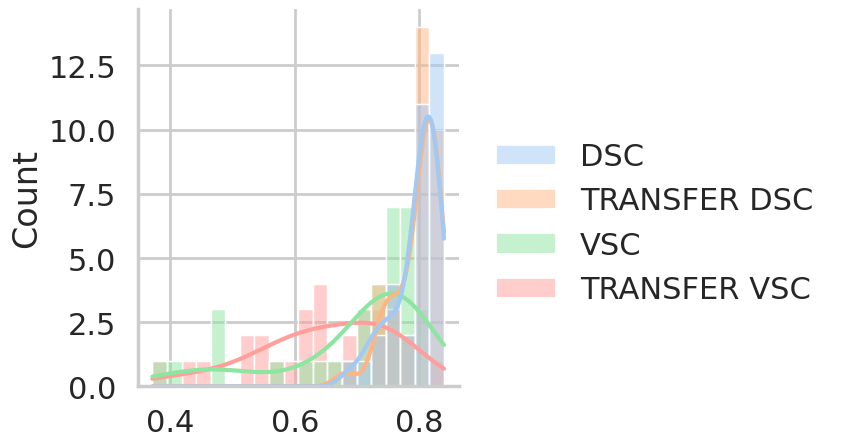

In [129]:
def overall_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_cat(y_apps_test[week], test[week])[1])
    transfer_res_list.append(dd_acc_cat(y_apps_test_tdsc[week], test[week])[1])
    

  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_cat(y_apps_test_vsc[week], test[week])[1])
    tvsc_res_list.append(dd_acc_cat(y_apps_test_tvsc[week], test[week])[1])

  average_df = pd.DataFrame(
      {'DSC': mix_res_list,
      'TRANSFER DSC': transfer_res_list,
      'VSC': vsc_res_list,# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
      'TRANSFER VSC': tvsc_res_list,# + [np.mean(tvsc_res_list)],
      }
      )
  plt.figure(figsize=(15,16))
  sns.displot(average_df, kde=True, bins=20)
  #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
  plt.savefig(fname='Distribution of Accuracies.png')

  return round(np.mean(mix_res_list), 3), round(np.mean(transfer_res_list), 3), round(np.mean(vsc_res_list), 3), round(np.mean(tvsc_res_list), 3)


dsc, tdsc, vsc, tvsc = overall_accs_report(weeks_to_train)
  

print('average DD accuracy on weeks for Mix DSC', dsc)
print('average DD accuracy on weeks for Transfer DSC', tdsc)
print('average DD accuracy on weeks for Mix VSC', vsc)
print('average DD accuracy on weeks for Transfer VSC', tvsc)


def per_cat_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_cat(y_apps_test[week], test[week])[2])
    transfer_res_list.append(dd_acc_cat(y_apps_test_tdsc[week], test[week])[2])
    

  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_cat(y_apps_test_vsc[week], test[week])[2])
    tvsc_res_list.append(dd_acc_cat(y_apps_test_tvsc[week], test[week])[2])

  for cat_ind, cat in enumerate(appliance_categories):
    average_df = pd.DataFrame(
        {'DSC': [item[cat] for item in mix_res_list],
        'TRANSFER DSC': [item[cat] for item in transfer_res_list],
        'VSC': [item[cat] for item in vsc_res_list],# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
        'TRANSFER VSC': [item[cat] for item in tvsc_res_list],# + [np.mean(tvsc_res_list)],
        }
        )
    plt.figure(figsize=(15,16))
    sns.displot(average_df, kde=True, bins=20)
    #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks for {}'.format(cat))
    plt.savefig(fname='Distribution of Accuracies for {}.png'.format(cat))

  return round(np.mean([item[cat] for item in mix_res_list]), 3), round(np.mean([item[cat] for item in transfer_res_list]), 3), round(np.mean([item[cat] for item in vsc_res_list]), 3), round(np.mean([item[cat] for item in tvsc_res_list]), 3)






In [1]:
def overall_non_zero_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_cat_non_zero(y_apps_test[week], test[week]))
    transfer_res_list.append(dd_acc_cat_non_zero(y_apps_test_tdsc[week], test[week]))
    

  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_cat_non_zero(y_apps_test_vsc[week], test[week]))
    tvsc_res_list.append(dd_acc_cat_non_zero(y_apps_test_tvsc[week], test[week]))

  average_df = pd.DataFrame(
      {'DSC': mix_res_list,
      'TRANSFER DSC': transfer_res_list,
      'VSC': vsc_res_list,# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
      'TRANSFER VSC': tvsc_res_list,# + [np.mean(tvsc_res_list)],
      }
      )
  plt.figure(figsize=(15,16))
  sns.displot(average_df, kde=True, bins=20)
  #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
  plt.savefig(fname='Distribution of Accuracies.png')

  return round(np.mean(mix_res_list), 3), round(np.mean(transfer_res_list), 3), round(np.mean(vsc_res_list), 3), round(np.mean(tvsc_res_list), 3)

#dsc, tdsc, vsc, tvsc = overall_non_zero_accs_report(weeks_to_train)
  

print('average DD accuracy on weeks for Mix DSC', dsc)
print('average DD accuracy on weeks for Transfer DSC', tdsc)
print('average DD accuracy on weeks for Mix VSC', vsc)
print('average DD accuracy on weeks for Transfer VSC', tvsc)



In [131]:
from sklearn.metrics import mean_squared_error

def dd_acc_cat(y_apps, data, target_only=False):
  s = 0
  acc_dict = dict()
  for cat_ind, cat in enumerate(appliance_categories):
    y_app = y_apps[cat][:,0,:]
    if target_only:
      y_real = data['X'][cat].iloc[:,target_ind:].values
    else:
      y_real = data['X'][cat].values
    s += np.sum(np.abs(y_real - y_app), axis=0)
    acc_dict[cat] = np.sum(np.abs(y_real - y_app), axis=0)

  if target_only:
    den = 2*data['X_bar'].iloc[:,target_ind:].sum(axis=0).values
  else: 
    den = 2*data['X_bar'].sum(axis=0).values
  return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), {cat: 1 - v/den for cat,v in acc_dict.items()}


week = 0
def dd_acc_per_category(y_apps, data, target_only=False):
    s = 0
    error_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        y_app = y_apps[cat][:,0,:]
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        s += np.sum(np.abs(y_real - y_app), axis=0)
        error_dict[cat] = np.sqrt(mean_squared_error(y_real, y_app)), np.sqrt(mean_squared_error(y_real, y_app))/np.linalg.norm(y_real, 2)
        
    return error_dict

In [ ]:
def per_cat_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_per_category(y_apps_test[week], test[week]))
    transfer_res_list.append(dd_acc_per_category(y_apps_test_tdsc[week], test[week]))
    

  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_per_category(y_apps_test_vsc[week], test[week]))
    tvsc_res_list.append(dd_acc_per_category(y_apps_test_tvsc[week], test[week]))

  for cat_ind, cat in enumerate(appliance_categories):
    average_df = pd.DataFrame(
        {'DSC': [item[cat] for item in mix_res_list],
        'TRANSFER DSC': [item[cat] for item in transfer_res_list],
        'VSC': [item[cat] for item in vsc_res_list],# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
        'TRANSFER VSC': [item[cat] for item in tvsc_res_list],# + [np.mean(tvsc_res_list)],
        }
        )

  for cat in appliance_categories:
      errors_mix = [d[cat][0] for d in mix_res_list]
      print('average DSC error for {} is {}'.format(cat, np.round(np.mean(errors_mix))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in mix_res_list]), 3)))
      errors_source = [d[cat][0] for d in transfer_res_list]
      print('average T-DSC error for {} is {}'.format(cat, np.round(np.mean(errors_source))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in transfer_res_list]), 3)))
      errors_target = [d[cat][0] for d in vsc_res_list]
      print('average VSC error for {} is {}'.format(cat, np.round(np.mean(errors_target))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in vsc_res_list]), 3)))
      errors_tsc = [d[cat][0] for d in tvsc_res_list]
      print('average T-VSC error for {} is {}'.format(cat, np.round(np.mean(errors_tsc))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in tvsc_res_list]), 3)))
      print("\n")

    
  return errors_mix, errors_source, errors_target, errors_tsc


sc_cat, ssc_cat, tarsc_cat, tsc_cat = per_cat_accs_report(weeks_to_train)
  
